In [27]:
#!pip install -U --user pandas

  Using cached https://files.pythonhosted.org/packages/99/f0/f99700ef327e51d291efdf4a6de29e685c4d198cbf8531541fc84d169e0e/pandas-1.3.5.tar.gz
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Using cached https://files.pythonhosted.org/packages/6d/ad/ff3b21ebfe79a4d25b4a4f8e5cf9fd44a204adb6b33c09010f566f51027a/numpy-1.21.6-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl
  Created wheel for pandas: filename=pandas-1.3.5-cp37-cp37m-linux_x86_64.whl size=32202920 sha256=07fc14c78dc8c2ef17ff9fbefe96629628ac18b75847c449fb47104463e5ce96
  Stored in directory: /global/scratch/projects/fc_songlab/gbenegas/.cache/pip/wheels/5c/f4/45/389dc711f0c5ff9adeb5245397ab18bf75182e8cff9fbfa916
Successfully built pandas
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu
from scipy.special import expit as sigmoid

In [2]:
#cis_eQTL = pd.read_csv("~/Downloads/ciseqtl.csv", sep="\t", skiprows=10) # TODO: should also get the trans-eqtl
#cis_eQTL

In [3]:
#df = pd.read_parquet("../mlm/vep.parquet")
#df = df[df.AN >= 2000]
#df = df[(df.AC != 0) & (df.AC != df.AN)]
#df["alt_AF"] = df.AC / df.AN
#df.model_llr = df.apply(lambda row: row.model_llr if row.alt_AF < 0.5 else -row.model_llr, axis=1)
#df["ref_AF"] = 1 - df.alt_AF
#df["alt_AC"] = df.AC
#df["ref_AC"] = df.AN - df.AC
#df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
#df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
#df

In [44]:
#model_name = "DeepSEA"
#model_name = "DNABERT"
#model_name = "PlantBert"
#model_name = "ConvNet"
model_name = "DeepSEA_10epochs"


df = pd.read_parquet(f"vep_{model_name}.parquet")
pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
df = df[df.AN >= 2000]
df = df[(df.AC != 0) & (df.AC != df.AN)]
df["alt_AF"] = df.AC / df.AN
df["ref_AF"] = 1 - df.alt_AF
df["alt_AC"] = df.AC
df["ref_AC"] = df.AN - df.AC
df["AC"] = df[["ref_AC", "alt_AC"]].min(axis=1)
df["AF"] = df[["ref_AF", "alt_AF"]].min(axis=1)
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,model_pred_ref_DHS_Ath_flower_14_days,model_pred_ref_DHS_Ath_open_flower_normal,...,model_pred_alt_TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,model_pred_alt_TFBS_AT5G65310_Ath_seedling_normal,model_pred_alt_TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,model_pred_alt_TFBS_AT5G67300_Ath_seedling_normal,model_pred_alt_TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1,alt_AF,ref_AF,alt_AC,ref_AC,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,-5.300405,-8.350435,...,-4.290177,-3.825251,-4.158820,-4.951073,-2.516432,0.180943,0.819057,376,1702,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,-5.077155,-7.957571,...,-4.351302,-3.930233,-4.241156,-5.012388,-2.273276,0.000958,0.999042,2,2086,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,-5.087812,-7.921375,...,-3.605511,-3.245859,-3.730060,-4.437348,-1.996634,0.001896,0.998104,4,2106,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,-5.325172,-8.072798,...,-4.277792,-3.910690,-4.223676,-5.033829,-2.321163,0.002828,0.997172,6,2116,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,-4.914903,-7.775746,...,-4.526845,-4.120674,-4.442614,-5.216969,-2.192632,0.000941,0.999059,2,2124,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Chr5,1770443,G,A,930,2046,AT5G05880.1,795,-1.957748,-4.490550,...,-1.814897,-1.541044,-1.999743,-2.312730,-1.243055,0.545455,0.454545,1116,930,0.454545
99996,Chr5,1770459,A,T,30,2084,AT5G05880.1,811,-2.166660,-4.850597,...,-2.224570,-1.893388,-2.422246,-2.766310,-1.296610,0.014395,0.985605,30,2054,0.014395
99997,Chr5,1770460,T,G,20,2074,AT5G05880.1,812,-1.995644,-4.708929,...,-2.677238,-2.342667,-2.747791,-3.162159,-1.379254,0.009643,0.990357,20,2054,0.009643
99998,Chr5,1770613,G,C,2,2002,AT5G05880.1,965,-2.312292,-6.034106,...,-3.992094,-3.437990,-3.807658,-4.391407,-2.198277,0.000999,0.999001,2,2000,0.000999


In [45]:
df[pred_cols] = sigmoid(df[pred_cols])

(array([6737269., 1340812.,  769291.,  501980.,  373338.,  309904.,
         262400.,  224899.,  198504.,  181167.]),
 array([2.10862808e-43, 9.99979179e-02, 1.99995836e-01, 2.99993754e-01,
        3.99991672e-01, 4.99989590e-01, 5.99987507e-01, 6.99985425e-01,
        7.99983343e-01, 8.99981261e-01, 9.99979179e-01]),
 <a list of 10 Patch objects>)

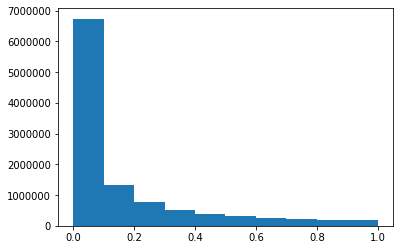

In [46]:
plt.hist(df[pred_alt_cols].values.ravel())

(array([6737269., 1340812.,  769291.,  501980.,  373338.,  309904.,
         262400.,  224899.,  198504.,  181167.]),
 array([2.10862808e-43, 9.99979179e-02, 1.99995836e-01, 2.99993754e-01,
        3.99991672e-01, 4.99989590e-01, 5.99987507e-01, 6.99985425e-01,
        7.99983343e-01, 8.99981261e-01, 9.99979179e-01]),
 <a list of 10 Patch objects>)

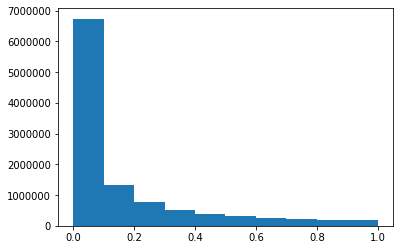

In [47]:
plt.hist(df[pred_alt_cols].values.ravel())

In [48]:
feature_names = ["_".join(col.split("_")[3:]) for col in pred_ref_cols]
delta_pred_cols = [f"delta_pred_{f}" for f in feature_names]
df.loc[:, delta_pred_cols] = df[pred_alt_cols].values - df[pred_ref_cols].values
#df.loc[:, delta_pred_cols] = df[pred_ref_cols].values - df[pred_alt_cols].values

df[delta_pred_cols] = df[delta_pred_cols].abs()
df[delta_pred_cols]

,delta_pred_DHS_Ath_flower_14_days,delta_pred_DHS_Ath_open_flower_normal,delta_pred_DHS_Ath_inflorescence_normal,delta_pred_DHS_Ath_leaf_normal,delta_pred_DHS_Ath_root_normal,delta_pred_DHS_Ath_root_7_days,delta_pred_DHS_Ath_root_hair_7_days,delta_pred_DHS_Ath_root_non_hair_7_days,delta_pred_DHS_Ath_root_non_hair_10_days,delta_pred_DHS_Ath_seed_coat_4_days_past_anthesis_rep1,...,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep2,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep3,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep4,delta_pred_TFBS_AT5G63790_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G63790_Ath_seedling_normal,delta_pred_TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G65310_Ath_seedling_normal,delta_pred_TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G67300_Ath_seedling_normal,delta_pred_TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1
0,0.000415,0.000036,0.000035,0.000397,0.002380,0.000050,0.000150,0.000526,0.002078,0.000304,...,0.003489,0.002980,0.000897,0.000380,0.000331,0.001396,0.002041,0.001099,0.000491,0.001565
1,0.000848,0.000110,0.000426,0.001255,0.005415,0.002051,0.002009,0.002578,0.004753,0.000650,...,0.003428,0.002642,0.001013,0.000288,0.000007,0.000456,0.001005,0.000303,0.000137,0.003141
2,0.005222,0.000575,0.006772,0.006533,0.015607,0.010635,0.008117,0.009506,0.012689,0.004176,...,0.006627,0.004401,0.004485,0.000330,0.000121,0.001523,0.000880,0.000765,0.000587,0.023420
3,0.000183,0.000039,0.001767,0.000353,0.001802,0.000973,0.000544,0.000465,0.000799,0.001058,...,0.001268,0.000015,0.000428,0.001038,0.000591,0.002761,0.003552,0.001958,0.001107,0.007340
4,0.004406,0.000493,0.002209,0.006730,0.022296,0.009514,0.009383,0.012101,0.019275,0.002983,...,0.009265,0.007291,0.003819,0.001472,0.000418,0.001265,0.001080,0.000523,0.000316,0.016788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.011288,0.000192,0.006143,0.007755,0.011881,0.006713,0.005315,0.002212,0.011616,0.000416,...,0.002756,0.005312,0.001559,0.002019,0.002400,0.008596,0.011928,0.009772,0.009024,0.006909
99996,0.009379,0.001137,0.016235,0.010650,0.020868,0.024535,0.018340,0.020101,0.024955,0.012743,...,0.004049,0.002935,0.000873,0.002665,0.002742,0.019629,0.023645,0.010250,0.009010,0.013457
99997,0.005246,0.001381,0.014525,0.002481,0.002504,0.022951,0.019379,0.019377,0.009695,0.014009,...,0.002572,0.003864,0.002098,0.000540,0.000738,0.005851,0.008470,0.006367,0.005215,0.014985
99998,0.003765,0.000148,0.001595,0.001307,0.001678,0.000930,0.000967,0.001986,0.002522,0.000964,...,0.002393,0.000541,0.002304,0.002146,0.000970,0.002749,0.003921,0.002773,0.001683,0.009774


In [49]:
# normalization
#df[pred_cols] = df[pred_cols] / df[pred_cols].abs().max()
#df[pred_cols] = df[pred_cols] / df[pred_cols].abs().quantile(0.99)
#df[pred_cols] = df[pred_cols] / df[pred_cols].abs().quantile(0.75)

In [50]:
#df[pred_cols].std()

In [51]:
df.AC.value_counts()

2       39008
4       10387
6        5383
8        3634
10       2825
        ...  
1084        2
1108        2
1114        1
1102        1
1106        1
Name: AC, Length: 554, dtype: int64

In [52]:
df[["AN", "AC", "AF"]].describe()

,AN,AC,AF
count,99996.000000,99996.000000,99996.000000
mean,2178.436977,74.742990,0.034711
std,61.213679,183.221915,0.085421
min,2000.000000,2.000000,0.000882
25%,2144.000000,2.000000,0.000917
50%,2196.000000,6.000000,0.002676
75%,2226.000000,34.000000,0.016053
max,2270.000000,1114.000000,0.500000


In [53]:
values = df[delta_pred_cols].values
#df.loc[:, "delta_pred_l1_norm"] = np.linalg.norm(values, ord=1, axis=1)
df.loc[:, "delta_pred_l2_norm"] = np.linalg.norm(values, ord=2, axis=1)
#df.loc[:, "delta_pred_linf_norm"] = np.linalg.norm(values, ord=np.inf, axis=1)
df

,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,model_pred_ref_DHS_Ath_flower_14_days,model_pred_ref_DHS_Ath_open_flower_normal,...,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep3,delta_pred_TFBS_AT5G61850_Ath_seedling_complete_seedlings_rep4,delta_pred_TFBS_AT5G63790_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G63790_Ath_seedling_normal,delta_pred_TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G65310_Ath_seedling_normal,delta_pred_TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,delta_pred_TFBS_AT5G67300_Ath_seedling_normal,delta_pred_TFBS_AT5G17430_Ath_somatic_embryo_24-D_induced_somatic_embryos_rep1,delta_pred_l2_norm
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,0.004965,0.000236,...,0.002980,0.000897,0.000380,0.000331,0.001396,0.002041,0.001099,0.000491,0.001565,0.031728
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,0.006199,0.000350,...,0.002642,0.001013,0.000288,0.000007,0.000456,0.001005,0.000303,0.000137,0.003141,0.017260
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,0.006134,0.000363,...,0.004401,0.004485,0.000330,0.000121,0.001523,0.000880,0.000765,0.000587,0.023420,0.049464
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,0.004844,0.000312,...,0.000015,0.000428,0.001038,0.000591,0.002761,0.003552,0.001958,0.001107,0.007340,0.027485
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,0.007283,0.000420,...,0.007291,0.003819,0.001472,0.000418,0.001265,0.001080,0.000523,0.000316,0.016788,0.052602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,Chr5,1770443,G,A,930,2046,AT5G05880.1,795,0.123711,0.011090,...,0.005312,0.001559,0.002019,0.002400,0.008596,0.011928,0.009772,0.009024,0.006909,0.053523
99996,Chr5,1770459,A,T,30,2084,AT5G05880.1,811,0.102785,0.007763,...,0.002935,0.000873,0.002665,0.002742,0.019629,0.023645,0.010250,0.009010,0.013457,0.092557
99997,Chr5,1770460,T,G,20,2074,AT5G05880.1,812,0.119661,0.008934,...,0.003864,0.002098,0.000540,0.000738,0.005851,0.008470,0.006367,0.005215,0.014985,0.066743
99998,Chr5,1770613,G,C,2,2002,AT5G05880.1,965,0.090110,0.002390,...,0.000541,0.002304,0.002146,0.000970,0.002749,0.003921,0.002773,0.001683,0.009774,0.025281


In [54]:
#delta_norm = "delta_pred_l1_norm"
delta_norm = "delta_pred_l2_norm"
#delta_norm = "delta_pred_linf_norm"
#delta_norm = "model_llr"

In [55]:
#df["SNP_matching_id"] = df.chromosome.str.lower() + "_" + (df.pos+1).astype(str)
#df["eQTL"] = df.SNP_matching_id.isin(cis_eQTL.SNP.values)
#df.eQTL.value_counts()
# TODO: should match AF in eQTL and noneQTL to be compared

In [56]:
df["Singleton"] = df.AC == 2
df.Singleton.value_counts()

False    60988
True     39008
Name: Singleton, dtype: int64

In [57]:
#df["logAF"] = np.log(df.AF)
#sns.histplot(data=df, x="logAF", y="delta_pred_l2_norm", bins=300)

In [58]:
#df["logAF_bin"] = pd.cut(df.logAF, 5)

In [59]:
spearmanr(df.AC, df[delta_norm])

SpearmanrResult(correlation=-0.022325644562982656, pvalue=1.6573842573676686e-12)

In [60]:
df.AC.max()

1114

In [61]:
df["AC_bin"] = pd.cut(df.AC, [0.0, 2.0, 10.0, 100.0, 300.0, 1115.0])
df.AC_bin.value_counts()

(0.0, 2.0]         39008
(10.0, 100.0]      23314
(2.0, 10.0]        22229
(300.0, 1115.0]     8180
(100.0, 300.0]      7265
Name: AC_bin, dtype: int64

In [62]:
global_percentile_99 = np.percentile(df[delta_norm], 99)
global_percentile_1 = np.percentile(df[delta_norm], 1)
global_percentile_1, global_percentile_99

(0.011365310441118204, 0.7384809128940446)

In [63]:
category = "AC_bin"
#category = "logAF_bin"
#category = "Singleton"
#category = "eQTL"

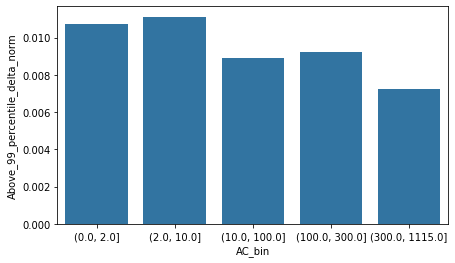

In [64]:
df["Above_99_percentile_delta_norm"] = df[delta_norm] > global_percentile_99
df2 = df.groupby(category)["Above_99_percentile_delta_norm"].mean().to_frame().reset_index()
plt.figure(figsize=(7, 4))
sns.barplot(data=df2, x=category, y="Above_99_percentile_delta_norm", color="C0")
# TODO: could plot a horizontal line at 1 percent. also express it as 1 percent instead of 0.01

In [65]:
#df["below_1_percentile_delta_norm"] = df[delta_norm] < global_percentile_1
#df2 = df.groupby(category)["below_1_percentile_delta_norm"].mean().to_frame().reset_index()
#plt.figure(figsize=(7, 4))
#sns.barplot(data=df2, x=category, y="below_1_percentile_delta_norm", color="C0")

In [66]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

percentiles = [95, 99, 99.9]

groupby = df.groupby(category)[delta_norm].agg([percentile(p) for p in percentiles])
#print(groupby)
x = groupby.melt(ignore_index=False).reset_index()
x

,AC_bin,variable,value
0,"(0.0, 2.0]",percentile_95,0.380640
1,"(2.0, 10.0]",percentile_95,0.388820
2,"(10.0, 100.0]",percentile_95,0.361195
3,"(100.0, 300.0]",percentile_95,0.346717
4,"(300.0, 1115.0]",percentile_95,0.341098
5,"(0.0, 2.0]",percentile_99,0.756720
6,"(2.0, 10.0]",percentile_99,0.766158
7,"(10.0, 100.0]",percentile_99,0.716502
8,"(100.0, 300.0]",percentile_99,0.719702
9,"(300.0, 1115.0]",percentile_99,0.660320


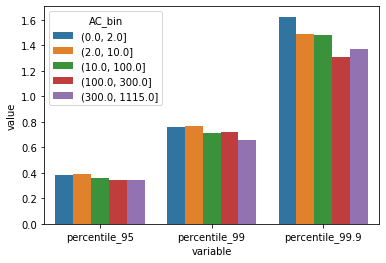

In [67]:
sns.barplot(data=x, x="variable", y="value", hue=category)

In [68]:
sns.ecdfplot(data=df, x=delta_norm, hue=category, palette="viridis")
plt.xlim([0, 2])
plt.ylim([0.95, 1.0])

AttributeError: module 'seaborn' has no attribute 'ecdfplot'

In [69]:
sns.ecdfplot(data=df, x=delta_norm, hue=category, palette="viridis")
plt.xlim([0, 0.3])
plt.ylim([0.4, 0.6])

AttributeError: module 'seaborn' has no attribute 'ecdfplot'

In [70]:
#df_eQTL = df[df.eQTL]
#df_eQTL = df_eQTL.merge(cis_eQTL, how="left", left_on="SNP_matching_id", right_on="SNP").sort_values(["chromosome", "pos"])
#df_eQTL

In [71]:
#sns.scatterplot(data=df_eQTL, x="Beta", y=delta_norm)

In [72]:
#sns.scatterplot(data=df_eQTL, x="p-value", y=delta_norm)

In [73]:
#sns.scatterplot(data=df_eQTL, x="t-stat", y=delta_norm)

In [74]:
#df_eQTL["abs_t-stat"] = df_eQTL["t-stat"].abs()
#sns.scatterplot(data=df_eQTL, x="abs_t-stat", y=delta_norm)

In [75]:
#spearmanr(df_eQTL["abs_t-stat"], df_eQTL[delta_norm])

In [76]:
#mannwhitneyu(
#    df_eQTL.loc[df_eQTL.Beta.abs() < 0.5, delta_norm],
#    df_eQTL.loc[df_eQTL.Beta.abs() >= 0.5, delta_norm],
#    alternative="greater")

In [77]:
#df_eQTL.groupby("closest_TSS").size().nlargest()

In [78]:
#df_locus = df_eQTL[df_eQTL.closest_TSS=="AT5G63570.1"]

In [79]:
#sns.lineplot(data=df_locus, x="dist_to_TSS", y=delta_norm)

In [80]:
#sns.lineplot(data=df_locus, x="dist_to_TSS", y="t-stat", ci=None)

In [81]:
#sns.lineplot(data=df_locus, x="dist_to_TSS", y="Beta", ci=None)

In [82]:
#spearmanr(df_locus["abs_t-stat"], df_locus[delta_norm])

In [83]:
df["Status"] = "Neither"
df.loc[df.AC <= 10, "Status"] = "Rare"
df.loc[df.AC > 100, "Status"] = "Common"
df.Status.value_counts()

Rare       61237
Neither    23314
Common     15445
Name: Status, dtype: int64

In [84]:
mannwhitneyu(df.loc[df.Status=="Rare", delta_norm], df.loc[df.Status=="Common", delta_norm], alternative="greater")

MannwhitneyuResult(statistic=494850943.0, pvalue=2.174913843954976e-19)

In [85]:
# this should work with the latest scipy
#mannwhitneyu(df.loc[df.Status=="Rare", delta_pred_cols], df.loc[df.Status=="Common", delta_pred_cols], alternative="greater")

In [86]:
p_values = np.array([
    mannwhitneyu(
        df.loc[df.Status=="Rare", delta_pred_col],
        df.loc[df.Status=="Common", delta_pred_col],
        alternative="greater"
        #"two-sided",
    ).pvalue
    for delta_pred_col in delta_pred_cols
])
p_values

array([1.59902307e-26, 3.25988750e-44, 7.63439827e-41, 2.13334390e-04,
       5.14291674e-11, 5.56150356e-46, 8.55607629e-50, 2.38123843e-43,
       7.75350295e-24, 3.54243151e-52, 1.51041862e-38, 7.86447183e-49,
       5.78787801e-34, 2.49706129e-03, 9.51779796e-39, 8.19472748e-38,
       2.21534125e-42, 8.56841434e-43, 3.36952231e-24, 1.31140331e-47,
       6.94939006e-49, 2.34894431e-47, 1.55182721e-46, 1.00000000e+00,
       9.99999960e-01, 9.99969475e-01, 1.00000000e+00, 1.00000000e+00,
       9.99999970e-01, 9.99999987e-01, 9.99999957e-01, 1.00000000e+00,
       9.99970108e-01, 4.54783236e-01, 2.68968712e-01, 3.46078881e-01,
       9.99987470e-01, 2.21040748e-05, 1.11655679e-03, 3.15162926e-05,
       9.99998964e-01, 8.73423077e-01, 2.38325570e-20, 6.80658422e-44,
       1.91875696e-44, 5.56728461e-36, 3.93148522e-33, 8.27826626e-34,
       1.18513925e-19, 4.95639196e-06, 4.86787747e-04, 2.33015456e-13,
       1.84819217e-24, 2.67444244e-37, 1.09670904e-31, 4.99309716e-32,
      

In [87]:
p_values.shape

(109,)

In [88]:
p_values_df = pd.DataFrame(data=np.expand_dims(p_values, axis=1), index=np.array(feature_names), columns=["p_value"])
p_values_df["delta_mean"] = (df.loc[df.Status=="Rare", delta_pred_cols].mean() - df.loc[df.Status=="Common", delta_pred_cols].mean()).values
p_values_df

,p_value,delta_mean
DHS_Ath_flower_14_days,1.599023e-26,0.001624
DHS_Ath_open_flower_normal,3.259888e-44,0.001556
DHS_Ath_inflorescence_normal,7.634398e-41,0.001428
DHS_Ath_leaf_normal,2.133344e-04,0.000920
DHS_Ath_root_normal,5.142917e-11,0.001038
...,...,...
TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,1.566888e-47,0.001571
TFBS_AT5G65310_Ath_seedling_normal,5.245838e-44,0.001530
TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,1.538929e-36,0.001530
TFBS_AT5G67300_Ath_seedling_normal,8.265019e-42,0.001403


In [89]:
p_values_df.to_csv(f"p_values_{model_name}.tsv", sep="\t")

In [90]:
model_names = ["DeepSEA", "DNABERT", "PlantBert", "ConvNet", "DeepSEA_10epochs"]
p_value_dfs = []
for model_name in model_names:
    p_value_df = pd.read_csv(f"p_values_{model_name}.tsv", sep="\t", index_col=0)
    p_value_df.p_value += 1e-300
    print(p_value_df.min())
    p_value_df["minuslog10p"] = -np.log10(p_value_df.p_value)
    p_value_df = p_value_df.add_suffix("_" + model_name)
    p_value_dfs.append(p_value_df)
p_value_df = pd.concat(p_value_dfs, axis=1)
p_value_df["Feature_type"] = p_value_df.index.str.split("_").str[0]
p_value_df

p_value       3.556366e-53
delta_mean   -6.612456e-04
dtype: float64
p_value       5.255922e-48
delta_mean   -7.870939e-04
dtype: float64
p_value       1.494870e-44
delta_mean   -1.297379e-03
dtype: float64
p_value       2.856477e-41
delta_mean   -1.460698e-03
dtype: float64
p_value       3.542432e-52
delta_mean   -6.066881e-04
dtype: float64


,p_value_DeepSEA,delta_mean_DeepSEA,minuslog10p_DeepSEA,p_value_DNABERT,delta_mean_DNABERT,minuslog10p_DNABERT,p_value_PlantBert,delta_mean_PlantBert,minuslog10p_PlantBert,p_value_ConvNet,delta_mean_ConvNet,minuslog10p_ConvNet,p_value_DeepSEA_10epochs,delta_mean_DeepSEA_10epochs,minuslog10p_DeepSEA_10epochs,Feature_type
DHS_Ath_flower_14_days,8.139459e-21,0.001871,20.089404,3.019876e-09,0.001863,8.520011,1.108422e-14,0.002304,13.955295,2.208611e-11,0.001782,10.655881,1.599023e-26,0.001624,25.796145,DHS
DHS_Ath_open_flower_normal,2.951053e-41,0.001685,40.530023,5.163433e-29,0.001836,28.287061,1.273068e-30,0.001797,29.895148,5.116226e-28,0.001448,27.291050,3.259888e-44,0.001556,43.486797,DHS
DHS_Ath_inflorescence_normal,4.484489e-36,0.001505,35.348287,5.046943e-25,0.001877,24.296972,5.629827e-31,0.001825,30.249505,7.548713e-24,0.001789,23.122127,7.634398e-41,0.001428,40.117225,DHS
DHS_Ath_leaf_normal,1.166702e-03,0.001155,2.933040,9.107048e-01,0.000829,0.040622,7.362521e-01,0.000868,0.132973,4.566019e-01,0.000738,0.340462,2.133344e-04,0.000920,3.670939,DHS
DHS_Ath_root_normal,5.053847e-09,0.001201,8.296378,5.226339e-03,0.001002,2.281802,1.778623e-04,0.001330,3.749916,3.068756e-03,0.000792,2.513038,5.142917e-11,0.001038,10.288791,DHS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TFBS_AT5G65310_Ath_seedling_ABA_treatment_for_4h,1.313737e-43,0.001958,42.881492,1.385204e-23,0.001793,22.858486,1.950060e-37,0.002928,36.709952,4.606196e-32,0.002197,31.336658,1.566888e-47,0.001571,46.804962,TFBS
TFBS_AT5G65310_Ath_seedling_normal,5.624741e-39,0.001880,38.249898,6.823557e-22,0.001829,21.165989,2.162717e-31,0.003012,30.665000,2.216865e-31,0.002107,30.654261,5.245838e-44,0.001530,43.280185,TFBS
TFBS_AT5G67300_Ath_seedling_ABA_treatment_for_4h,7.543776e-30,0.001844,29.122411,3.347116e-14,0.001608,13.475329,5.992447e-22,0.001773,21.222396,2.301445e-25,0.001952,24.637999,1.538929e-36,0.001530,35.812781,TFBS
TFBS_AT5G67300_Ath_seedling_normal,1.348509e-34,0.001676,33.870146,2.834543e-19,0.001762,18.547517,4.408006e-24,0.002078,23.355758,1.468346e-24,0.001760,23.833172,8.265019e-42,0.001403,41.082756,TFBS


In [91]:
#sns.scatterplot(data=p_value_df, x="minuslog10p_DeepSEA", y="minuslog10p_PlantBert", hue="Feature_type")
#plt.plot([0, 300], [0, 300], "--", color="gray")
#plt.gca().set_aspect('equal', 'box')

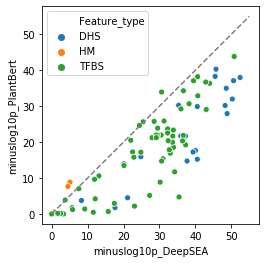

In [92]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DeepSEA", y="minuslog10p_PlantBert", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

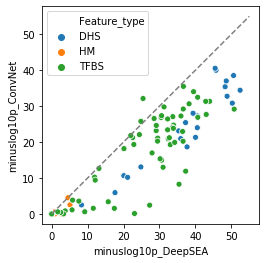

In [40]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DeepSEA", y="minuslog10p_ConvNet", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

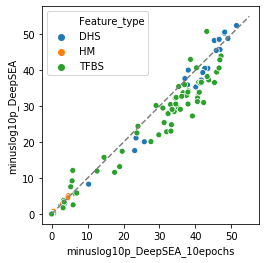

In [94]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DeepSEA_10epochs", y="minuslog10p_DeepSEA", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

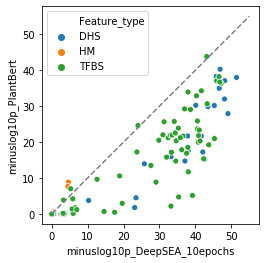

In [93]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DeepSEA_10epochs", y="minuslog10p_PlantBert", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

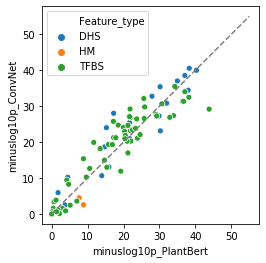

In [41]:
sns.scatterplot(data=p_value_df, x="minuslog10p_PlantBert", y="minuslog10p_ConvNet", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

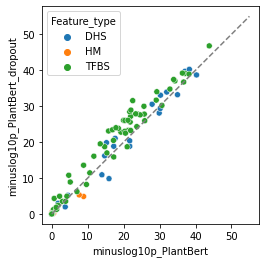

In [55]:
sns.scatterplot(data=p_value_df, x="minuslog10p_PlantBert", y="minuslog10p_PlantBert_dropout", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

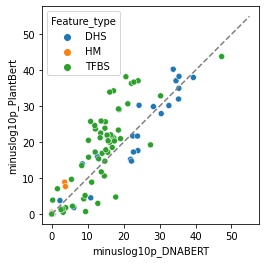

In [57]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DNABERT", y="minuslog10p_PlantBert", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

In [ ]:
sns.scatterplot(data=p_value_df, x="minuslog10p_PlantBert", y="minuslog10p_PlantBert_maxpool", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

In [ ]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DeepSEA", y="minuslog10p_PlantBert", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")

plt.gca().set_aspect('equal', 'box')

In [ ]:
sns.scatterplot(data=p_value_df, x="minuslog10p_DNABERT", y="minuslog10p_PlantBert", hue="Feature_type")
plt.plot([0, 55], [0, 55], "--", color="gray")

plt.gca().set_aspect('equal', 'box')

In [ ]:
sns.boxplot(data=p_value_df, x="Feature_type", y="minuslog10p_PlantBert", hue="Feature_type")

In [ ]:
sns.boxplot(data=p_value_df, x="Feature_type", y="minuslog10p_DeepSEA", hue="Feature_type")

In [ ]:
sns.boxplot(data=p_value_df, x="Feature_type", y="minuslog10p_DNABERT", hue="Feature_type")

In [ ]:
sns.scatterplot(data=p_value_df, x="delta_mean_DeepSEA", y="delta_mean_PlantBert", hue="Feature_type")
plt.plot([-0.0015, 0.0026], [-0.0015, 0.0026], "--", color="gray")
plt.gca().set_aspect('equal', 'box')

In [ ]:
#sns.scatterplot(data=df, x="dist_to_TSS", y=delta_norm)

In [ ]:
#df.dist_to_TSS.describe()

In [ ]:
#df.dist_to_TSS.hist()